# Explore Fashion Product Images

In [1]:
!which python

/Users/alykhan/Downloads/MultimodalAIFashion/venv/bin/python


In [5]:
pip install --upgrade --force-reinstall "numpy==1.26.4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 5.7 MB/s  0:00:03 eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pathlib import Path
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy 

#Collects the images and the descriptions 
RAW = Path('../data/raw/fashion-dataset')
styles_csv = RAW / 'styles.csv'
images_dir = RAW / 'images'

if not styles_csv.exists():
    raise FileNotFoundError("Run the download script first.")

df = pd.read_csv(styles_csv, on_bad_lines='skip')
print("Rows:", len(df))
df.head()

Rows: 44424


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


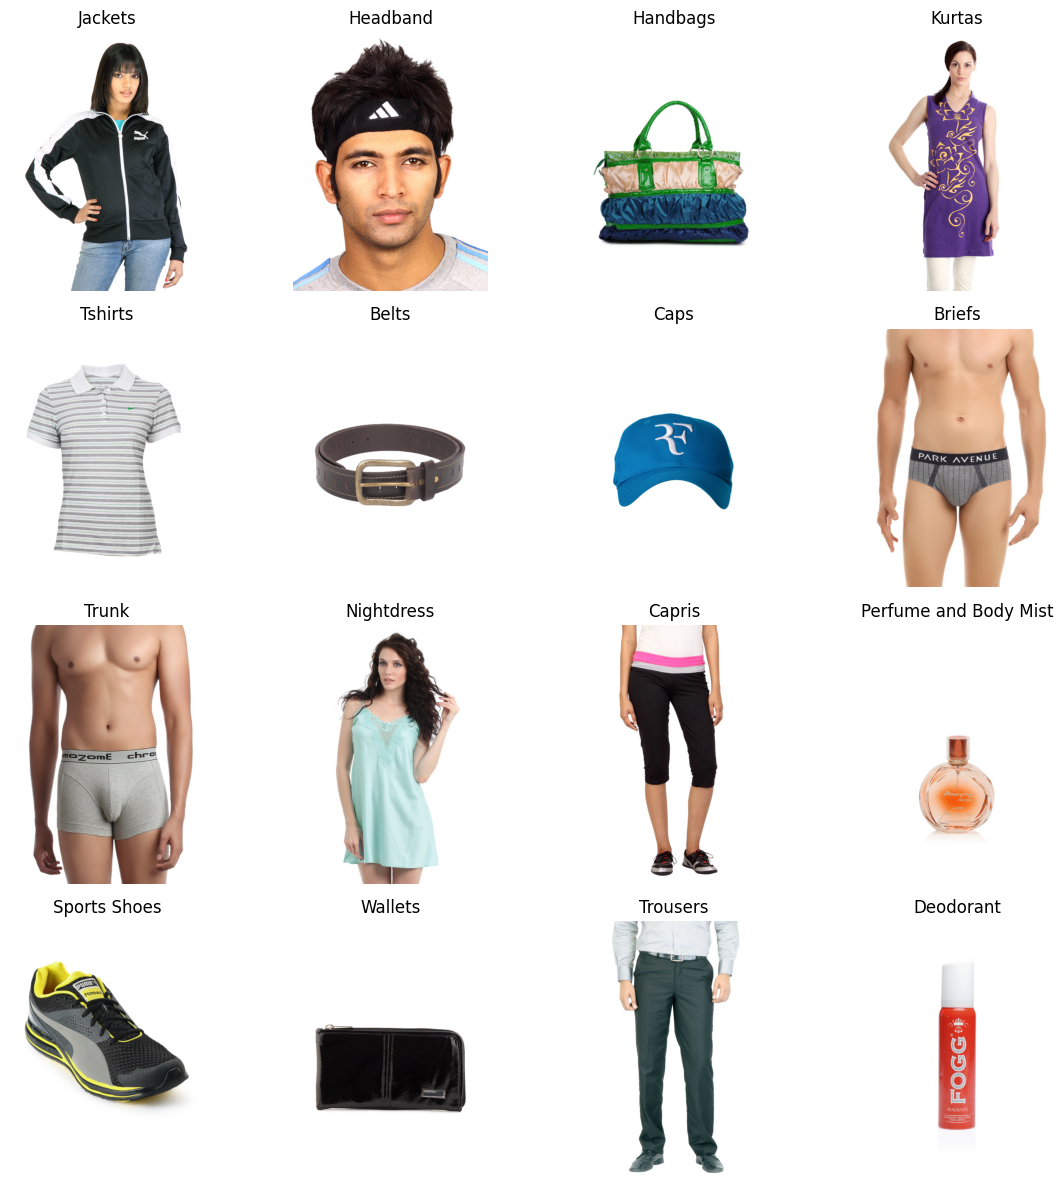

In [2]:
#Selects a random subset of 16 images, random state makes sure the same images are picked each time
sample_df = df.sample(n=16, random_state=42)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
axes = axes.flatten()

#Plots each image in the sample
for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img_path = images_dir / f"{row['id']}.jpg"
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        ax.imshow(img)
        ax.set_title(str(row.get('articleType', '')))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# Drop rows with missing articleType
df = df.dropna(subset=["articleType"])

# Keep only rows where the image file exists
df["image_path"] = df["id"].apply(lambda x: images_dir / f"{x}.jpg")
df = df[df["image_path"].apply(lambda x: x.exists())].reset_index(drop=True)

print(f"After dropping missing/invalid images: {len(df)} rows")

# Remove rare classes based on articleType counts
MIN_SAMPLES = 9
class_counts = df["articleType"].value_counts()
valid_classes = class_counts[class_counts >= MIN_SAMPLES].index
df = df[df["articleType"].isin(valid_classes)].reset_index(drop=True)

print(f"Remaining dataset size: {len(df)}")
print(f"Remaining number of classes: {df['articleType'].nunique()}")

After dropping missing/invalid images: 44419 rows
Remaining dataset size: 44283
Remaining number of classes: 109


# Image Augmentation and Preprocessing

In [4]:
#Resizing and Augmentation
from torchvision import transforms

#Training augmentations
train_transformations = transforms.Compose([
    #Resize
    transforms.Resize((224, 224)),
    #Mirrors clothing
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),                              # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

/Users/alykhan/Downloads/MultimodalAIFashion/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#Validation and test set transformations
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
from sklearn.preprocessing import LabelEncoder
import re
import json

#Encodes labels after rare-class filtering
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["articleType"])

#Saves mapping (class -> id)
label_mapping = {cls: int(i) for cls, i in zip(label_encoder.classes_,
                                               label_encoder.transform(label_encoder.classes_))}
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)
with open(processed_dir / "label_mapping.json", "w") as f:
    json.dump(label_mapping, f, indent=2)
print("Number of classes:", len(label_mapping))
print("Saved:", processed_dir / "label_mapping.json")

#Cleans text (once)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_name"] = df["productDisplayName"].apply(clean_text)

# NOTE: Do NOT recompute image_path or drop rows again here —
# you've already done that before removing rare classes.
print("Final dataset size:", len(df))
df.head()

Number of classes: 109
Saved: ../data/processed/label_mapping.json
Final dataset size: 44283


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path,label_id,clean_name
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,../data/raw/fashion-dataset/images/15970.jpg,79,turtle check men navy blue shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,../data/raw/fashion-dataset/images/39386.jpg,42,peter england men party blue jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,../data/raw/fashion-dataset/images/59263.jpg,107,titan women silver watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,../data/raw/fashion-dataset/images/21379.jpg,97,manchester united men solid black track pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,../data/raw/fashion-dataset/images/53759.jpg,102,puma men grey t shirt


In [7]:
import torch
from torch.utils.data import Dataset

#Creates a dataset that combines image, text, label
class FashionDataset(Dataset):
    
    def __init__(self, dataframe, image_transform=None, text_transform=None):
        #Dataframe: pandas DataFrame with columns: ['image_path', 'clean_name', 'label_id']
        #image_transform: torchvision transforms for images
        #text_transform: function to process text (optional, e.g., tokenizer)
        self.df = dataframe.reset_index(drop=True)
        self.image_transform = image_transform
        self.text_transform = text_transform

    #Returns the length of the dataframe
    def __len__(self):
        return len(self.df)

    #Gets an item and returns image, text, label
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        #Loads and preprocesses image
        img = Image.open(row["image_path"]).convert("RGB")
        if self.image_transform:
            img = self.image_transform(img)
        
        #Preprocesses text
        text = row["clean_name"]
        if self.text_transform:
            text = self.text_transform(text)
        
        label = int(row["label_id"])
        
        return img, text, label

In [8]:
from torch.utils.data import DataLoader

#Creates dataset
dataset = FashionDataset(df, image_transform=train_transformations)

#Creates DataLoader
loader = DataLoader(dataset, batch_size=4, shuffle=True)

#Gets a batch
images, texts, labels = next(iter(loader))

print("Image batch shape:", images.shape)
print("Example text:", texts[0])
print("Example label:", labels[0])

Image batch shape: torch.Size([4, 3, 224, 224])
Example text: puma women faas 300 black sports shoes
Example label: tensor(85)


In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
import json

#Seed to ensure reproducibility
RANDOM_STATE = 42

#Train (70%) vs Temporary (30% for val+test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=RANDOM_STATE)
train_index, temp_index = next(split1.split(df, df["label_id"]))

df_train = df.iloc[train_index].reset_index(drop=True)
df_temp = df.iloc[temp_index].reset_index(drop=True)

#Val (15%) vs Test (15%) from the temp set
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=RANDOM_STATE)
val_index, test_index = next(split2.split(df_temp, df_temp["label_id"]))

df_val = df_temp.iloc[val_index].reset_index(drop=True)
df_test = df_temp.iloc[test_index].reset_index(drop=True)

#Prints sizes
print(f"Train size: {len(df_train)}")
print(f"Val size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

#Saves indices for reproducibility
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

split_indices = {
    "train_index": train_index.tolist(),
    "val_index": temp_index[val_index].tolist(),
    "test_index": temp_index[test_index].tolist()
}

with open(processed_dir / "split_indices.json", "w") as f:
    json.dump(split_indices, f, indent=2)

print("Saved split indices:", processed_dir / "split_indices.json")

Train size: 30998
Val size: 6642
Test size: 6643
Saved split indices: ../data/processed/split_indices.json


In [10]:
#Loads indices from file
with open(processed_dir / "split_indices.json", "r") as f:
    split_indices = json.load(f)

train_index = split_indices["train_index"]
val_index = split_indices["val_index"]
test_index = split_indices["test_index"]

#Creates split DataFrames
train_df = df.iloc[train_index].reset_index(drop=True)
val_df = df.iloc[val_index].reset_index(drop=True)
test_df = df.iloc[test_index].reset_index(drop=True)

#Creates datasets
train_dataset = FashionDataset(train_df, image_transform=train_transformations)
val_dataset = FashionDataset(val_df, image_transform=val_transforms)
test_dataset = FashionDataset(test_df, image_transform=val_transforms)

In [11]:
#Creates dataloaders for each set
BATCH_SIZE = 32
NUM_WORKERS = 0

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [12]:
#Shows an image
images, texts, labels = next(iter(train_loader))
print("Images shape:", images.shape)
print("First text:", texts[0])
print("First label:", labels[0])

Images shape: torch.Size([32, 3, 224, 224])
First text: hm women silver heels
First label: tensor(38)


In [13]:
train_counts = numpy.bincount(train_df["label_id"])
print("Min samples per class:", train_counts.min())
print("Max samples per class:", train_counts.max())

Min samples per class: 6
Max samples per class: 4946


In [14]:
from collections import Counter

# Compute class weights
class_counts = Counter(df["label_id"])
num_classes = len(class_counts)
total_samples = sum(class_counts.values())

class_weights = torch.tensor(
    [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)],
    dtype=torch.float
)

# Save for later
torch.save(class_weights, processed_dir / "class_weights.pt")
print("Saved class weights:", processed_dir / "class_weights.pt")

Saved class weights: ../data/processed/class_weights.pt
